In [2]:
from GammaSimulations import GammaSimulations
import torch
import numpy as np

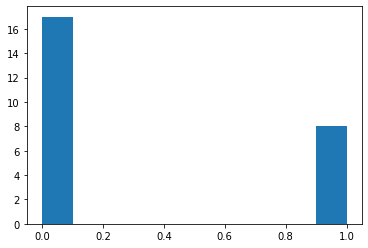

In [3]:
nr_components=25
nr_timepoints=50
nr_neurons=50
X=GammaSimulations().simulate_data(nr_components,nr_timepoints,nr_neurons)


In [3]:
U=np.zeros((nr_neurons,nr_components))
U=torch.tensor(U,requires_grad=True)
V=np.zeros((nr_components,nr_timepoints))
V=torch.tensor(V,requires_grad=True)
def forward(U,V):
    pred=U@V

In [4]:
U=torch.randn((nr_neurons,nr_components),requires_grad=True)
V=torch.randn((nr_components,nr_timepoints),requires_grad=True)
print(V)
print(U)

tensor([[ 1.5317, -0.8789, -0.3044,  ..., -0.8769, -1.7898, -1.5760],
        [ 0.7948,  0.3355,  0.9260,  ...,  0.3442,  0.9874,  0.1262],
        [ 0.8318, -1.6527,  0.0230,  ...,  1.5588, -1.7002,  1.8052],
        ...,
        [ 0.1139, -0.5214, -0.6159,  ..., -0.0650,  0.0774, -2.7786],
        [-0.1600,  0.3919,  1.1426,  ..., -1.7806, -0.6753, -0.5046],
        [-0.6630,  1.9471,  1.2255,  ...,  1.5098,  0.3425, -0.1440]],
       requires_grad=True)
tensor([[ 1.6846,  0.2410,  1.2868,  ..., -0.0880, -0.0597, -1.3190],
        [-1.6590, -1.4059,  0.0248,  ..., -0.4636,  0.6457,  1.6751],
        [-0.6774,  1.6490, -1.0414,  ...,  0.3609, -2.2637,  0.6661],
        ...,
        [ 0.0445,  1.1002, -0.1459,  ...,  0.0930, -1.2909,  1.9094],
        [ 0.6625, -0.1309,  0.2460,  ...,  0.5638,  0.5563, -0.0400],
        [-1.3606,  0.2419,  0.3053,  ...,  1.0757,  0.0797,  1.7173]],
       requires_grad=True)


In [10]:
from torch.autograd import Variable

def model(U,V):
    UV=U@V
    UV=Variable(UV,requires_grad=True)
    return UV
print((U@V).shape)
print(X.shape)
X_torch=torch.tensor(X,dtype=torch.double)
print(X_torch.shape)
def mse(t1,t2):
    diff=t1-t2
    print(diff)
    return torch.sum(diff*diff)/diff.numel()

loss_func = torch.nn.MSELoss()
U=Variable(U,requires_grad=True)
V=Variable(V,requires_grad=True)
X_torch=Variable(X_torch)
print(U)
print(V)
optimizer = torch.optim.SGD([U,V], 
                            lr=1e-6)
for i in range(0,10):
    preds=model(U,V)
    loss=loss_func(preds,X_torch)
    print(loss)
    #loss.backward()
    loss.backward()
    #print('bom',loss.backward())
    print('LOZZ',loss)
    print(U.grad)
    optimizer.step()
        

torch.Size([50, 50])
(50, 50)
torch.Size([50, 50])
tensor([[ 1.6846,  0.2410,  1.2868,  ..., -0.0880, -0.0597, -1.3190],
        [-1.6590, -1.4059,  0.0248,  ..., -0.4636,  0.6457,  1.6751],
        [-0.6774,  1.6490, -1.0414,  ...,  0.3609, -2.2637,  0.6661],
        ...,
        [ 0.0445,  1.1002, -0.1459,  ...,  0.0930, -1.2909,  1.9094],
        [ 0.6625, -0.1309,  0.2460,  ...,  0.5638,  0.5563, -0.0400],
        [-1.3606,  0.2419,  0.3053,  ...,  1.0757,  0.0797,  1.7173]],
       requires_grad=True)
tensor([[ 1.5317, -0.8789, -0.3044,  ..., -0.8769, -1.7898, -1.5760],
        [ 0.7948,  0.3355,  0.9260,  ...,  0.3442,  0.9874,  0.1262],
        [ 0.8318, -1.6527,  0.0230,  ...,  1.5588, -1.7002,  1.8052],
        ...,
        [ 0.1139, -0.5214, -0.6159,  ..., -0.0650,  0.0774, -2.7786],
        [-0.1600,  0.3919,  1.1426,  ..., -1.7806, -0.6753, -0.5046],
        [-0.6630,  1.9471,  1.2255,  ...,  1.5098,  0.3425, -0.1440]],
       requires_grad=True)


RuntimeError: Expected object of scalar type Float but got scalar type Double for argument #2 'target'

In [4]:
import torch
import torch.nn as nn

class NMF(nn.Module):
    def __init__(self, nr_neurons, nr_timepoints, nr_components):
        super(NMF, self).__init__()
        self.U = nn.Parameter(torch.rand(nr_neurons, nr_components, requires_grad=True))
        self.V = nn.Parameter(torch.rand(nr_components, nr_timepoints, requires_grad=True))

    def forward(self):
        return torch.matmul(self.U, self.V)

# some data cube Y: B x N and we want to factor it into K components
nr_components=25
nr_timepoints=50
nr_neurons=50
#Y = torch.rand(B,N) 
X_torch=torch.tensor(X,dtype=torch.float32)
Y=X_torch
nmf = NMF(nr_neurons, nr_timepoints, nr_components)
Y_ = nmf()
loss_fn = nn.MSELoss(reduction='sum')
loss = loss_fn(Y_, Y)
loss.backward()
print(loss)
n_epoch=10
for epoch in range(n_epoch):
    Y_ = nmf()
    loss = loss_fn(Y_, Y)
    nmf.zero_grad() # need to clear the old gradients
    loss.backward()

    for param in nmf.parameters():
        param.data = param.data - 1e-5 * param.grad
    print('U',nmf.U)
    nmf.U.data=torch.clamp(nmf.U.data,min=0)
    print(loss)

tensor(96555.5469, grad_fn=<MseLossBackward>)
U Parameter containing:
tensor([[0.3282, 0.0842, 0.4718,  ..., 0.7889, 0.9710, 0.3119],
        [0.2442, 0.3443, 0.5208,  ..., 0.8186, 0.1133, 0.4612],
        [0.5291, 0.3904, 0.7437,  ..., 0.4473, 0.3481, 0.4077],
        ...,
        [0.6995, 0.9734, 0.0887,  ..., 0.1859, 0.5963, 0.3645],
        [0.7095, 0.1793, 0.0781,  ..., 0.2468, 0.6545, 0.6847],
        [0.7709, 0.4255, 0.8734,  ..., 0.2014, 0.7222, 0.0990]],
       requires_grad=True)
tensor(96555.5469, grad_fn=<MseLossBackward>)
U Parameter containing:
tensor([[0.3255, 0.0814, 0.4695,  ..., 0.7865, 0.9682, 0.3095],
        [0.2408, 0.3407, 0.5177,  ..., 0.8155, 0.1098, 0.4580],
        [0.5263, 0.3874, 0.7412,  ..., 0.4448, 0.3452, 0.4051],
        ...,
        [0.6961, 0.9697, 0.0857,  ..., 0.1830, 0.5927, 0.3615],
        [0.7066, 0.1763, 0.0756,  ..., 0.2442, 0.6515, 0.6820],
        [0.7676, 0.4220, 0.8705,  ..., 0.1985, 0.7188, 0.0960]],
       requires_grad=True)
tensor(941

tensor(95353.3203, grad_fn=<MseLossBackward>)


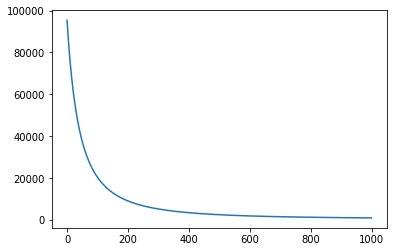

In [20]:
import torch
import torch.nn as nn

class NMF(nn.Module):
    def __init__(self, nr_neurons, nr_timepoints, nr_components):
        super(NMF, self).__init__()
        self.U = nn.Parameter(torch.rand(nr_neurons, nr_components, requires_grad=True))
        self.V = nn.Parameter(torch.rand(nr_components, nr_timepoints, requires_grad=True))

    def forward(self):
        return torch.matmul(self.U, self.V)
    

def fit_NMF(X,nr_components):
    nr_timepoints=X.shape[0]
    nr_neurons=X.shape[1]
    X_torch=torch.tensor(X,dtype=torch.float32)
    Y=X_torch
    nmf = NMF(nr_neurons, nr_timepoints, nr_components)
    Y_ = nmf()
    loss_fn = nn.MSELoss(reduction='sum')
    loss_lst=[]
    for epoch in range(n_epoch):
        Y_ = nmf()
        loss = loss_fn(Y_, Y)
        nmf.zero_grad() # need to clear the old gradients
        loss.backward()
        loss_lst.append(loss.item())
        for param in nmf.parameters():
            param.data = param.data - 1e-5 * param.grad
        #print('U',nmf.U)
        nmf.U.data=torch.clamp(nmf.U.data,min=0)
    plt.plot(loss_lst)
    return np.array(nmf.U.data),np.array(nmf.V.data)

# some data cube Y: B x N and we want to factor it into K components
nr_components=25
nr_timepoints=50
nr_neurons=50
#Y = torch.rand(B,N) 
X_torch=torch.tensor(X,dtype=torch.float32)
Y=X_torch
nmf = NMF(nr_neurons, nr_timepoints, nr_components)
Y_ = nmf()
loss_fn = nn.MSELoss(reduction='sum')
loss = loss_fn(Y_, Y)
loss.backward()
print(loss)
n_epoch=1000
loss_lst=[]
for epoch in range(n_epoch):
    Y_ = nmf()
    loss = loss_fn(Y_, Y)
    nmf.zero_grad() # need to clear the old gradients
    loss.backward()
    loss_lst.append(loss.item())
    for param in nmf.parameters():
        param.data = param.data - 1e-5 * param.grad
    #print('U',nmf.U)
    nmf.U.data=torch.clamp(nmf.U.data,min=0)
    #print(loss)
import matplotlib.pyplot as plt
plt.plot(loss_lst)

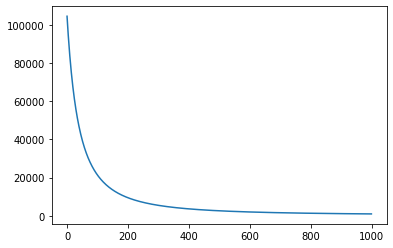

In [21]:
nr_components=25
nr_timepoints=50
nr_neurons=50
U,V=fit_NMF(X,25)

In [10]:
print(nmf.U.data)
nmf.V.data

tensor([[5.2555e-04, 4.4401e-01, 3.5670e-01,  ..., 5.7874e-01, 0.0000e+00,
         0.0000e+00],
        [4.5627e-01, 2.3142e-01, 2.4604e-01,  ..., 4.3477e-01, 3.9485e-01,
         0.0000e+00],
        [4.2965e-01, 5.0667e-02, 3.5420e-02,  ..., 1.5138e-01, 5.3795e-01,
         5.4601e-02],
        ...,
        [7.3139e-02, 1.6861e-01, 4.5290e-01,  ..., 4.7111e-01, 0.0000e+00,
         1.0178e-01],
        [6.2227e-01, 4.8483e-01, 6.6274e-01,  ..., 6.9584e-01, 1.6844e-01,
         0.0000e+00],
        [3.2384e-01, 2.5985e-01, 5.5453e-01,  ..., 2.7807e-01, 3.2543e-01,
         0.0000e+00]])


tensor([[ 0.2389, -0.0100,  0.2842,  ..., -0.1167,  0.3107,  0.1558],
        [ 0.2994,  0.0402,  0.1277,  ..., -0.2002, -0.0127,  0.3819],
        [-0.0689,  0.3304, -0.3409,  ...,  0.0157, -0.2609,  0.0895],
        ...,
        [-0.0860,  0.2430,  0.1415,  ..., -0.1211,  0.1670, -0.3830],
        [-0.3384, -0.2119,  0.4726,  ..., -0.0356,  0.0612,  0.2871],
        [ 0.1779,  0.5848, -0.0330,  ...,  0.5262,  0.1391,  0.2244]])